<a href="https://colab.research.google.com/github/katarinagresova/M7DataSP_2020/blob/erik_fscore/assignment_02/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data TODOs:
- ~~choose dataset~~
- ~~set way of loading data to this notebook~~  *Erik*

# Preprocessing TODOs:
- ~~check missing values~~ (there are none)
- ~~do one-hot encoding~~ (binned quality into bad and good)
- (optional: more preprocessing (would like to do outlier detection, if there will be time) )
- ~~split label~~
- ~~split train and test~~

# Model training TODOs:
- ~~create normalizer~~
- ~~define neural network~~
- ~~train neural network~~
- ~~plot the evolution of loss and/or accuracy as a number of epoch increases~~

#Evaluating TODOs
-~~ evaluate model on test data~~

# More layers TODOs

- ~~create a neural network with more layers~~
- ~~compare the two based on some measure~~
-~~plot the loss function instead of accuracy(accuracy is not a good measure when the classes are imballanced)~
- ~~maybe think of other measure such as precision, or f score~~

## Eriks personal TODOs
- ~~ask how to use pipeline std scaler in neural networks~~
- ask what how to proceed with unballanced classes
- ask input_shape ?  aby islo dat summary
- ask adam(0.001)

# Data import

---



In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from keras import backend as K




In [3]:
from google.colab import files
uploaded = files.upload()

Saving winequality-red.csv to winequality-red.csv


In [37]:
wine = pd.read_csv('winequality-red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Note that there is no cathegorical variable so there is no need to OneHotEncode.

In [38]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#Data preprocessing

As we can see, all our data is numerical. Let's check, if there are some missing values.

In [39]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

We are in luck my friend, there are no missing values. Let's change label - `quality` - in only two categories 'bad' and 'good' it makes it easier for classification. We split the label with median of quality (6) being border withween class labels

In [40]:
wine['quality'] = pd.cut(wine['quality'], bins = [0, 6, 8], labels = ['bad', 'good'])

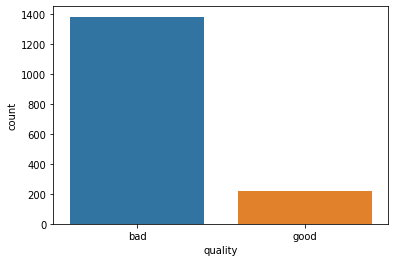

In [41]:
sns.countplot(x='quality', data = wine)

As we can see, the classes are unbalanced. Is the accuracy a good measure of our model? Let us define a better scorer for imbalanced classes - F1 score. We will come back to it later in the code.

In [54]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

And now some data splitting. First split data into train and test and then separate label column from data.

In [55]:
train_dataset = wine.sample(frac=0.8, random_state=42)
test_dataset = wine.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

label = 'quality'
train_labels = train_features.pop(label)== 'good'
test_labels = test_features.pop(label)== 'good'


Print some shapes to see if we did good.

In [56]:
train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((1279, 11), (320, 11), (1279,), (320,))

In order to use Neural network algorithm, we need to standardize the data to zero mean and unit variance.


In [57]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

#Neural Network
## One neuron model

Firstly, we create only one neuron, one layer model.

In [59]:
first_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
])

first_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 11)                23        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 12        
Total params: 35
Trainable params: 12
Non-trainable params: 23
_________________________________________________________________


In [60]:
first_model.compile(loss='binary_crossentropy',
                    optimizer =tf.keras.optimizers.Adam(0.001), metrics =['accuracy', f1_m] )
# do optimizer staci len 'adam' ?

In [61]:
%%time
history = first_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 6.62 s, sys: 436 ms, total: 7.05 s
Wall time: 5.72 s


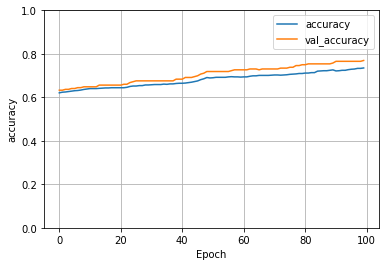

In [62]:
def plot_loss(history, measure = 'accuracy', valmeasure = 'val_accuracy'):
  plt.plot(history.history[measure], label=measure)
  plt.plot(history.history[valmeasure], label=valmeasure)
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel(measure)
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [63]:

# evaluation on test data
test_evaluation = {}
test_evaluation['first_model'] = first_model.evaluate(
    test_features,
    test_labels, verbose=1)
test_evaluation

10/10 [==============================] - 0s 1ms/step - loss: 2.6942 - accuracy: 0.7344 - f1_m: 0.0993


{'first_model': [2.6942336559295654, 0.734375, 0.0992986336350441]}

## One hidden layer
We added one hidden layer with 100 neurons.

In [65]:
# model definition
second_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
])

second_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy', f1_m])

In [66]:
%%time
history = second_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 6.81 s, sys: 476 ms, total: 7.28 s
Wall time: 5.64 s


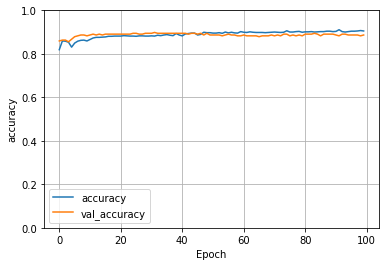

In [67]:
plot_loss(history)

In [68]:

test_evaluation['second_model'] = second_model.evaluate(
    test_features,
    test_labels, verbose=1)
test_evaluation

10/10 [==============================] - 0s 1ms/step - loss: 0.6938 - accuracy: 0.8969 - f1_m: 0.3376


{'first_model': [2.6942336559295654, 0.734375, 0.0992986336350441],
 'second_model': [0.6937808990478516, 0.8968750238418579, 0.3375757336616516]}

As we can see, the accuracy of the model with one hidden layer improved, as the one hidden layer on validation is almost 0.95. The accuracy on the test data also improved from 0.73 to 0.896 which might show a good progress.. But accuracy is the measure of well classified labels relative to all the labels. But as our classes are imbalanced, and F1 score is a much better indicator. One can see that the base model has F1 score on the test data only 0.0992. THe one hidden layer model has significantly better score of 0.337 but still is nowhere near the desired values close to 1. Lets add one more hidden layer

## Two hidden layers

In [69]:
# model definition
third_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
])

third_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy', f1_m])

In [70]:
%%time
history = third_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 7.67 s, sys: 577 ms, total: 8.25 s
Wall time: 6.33 s


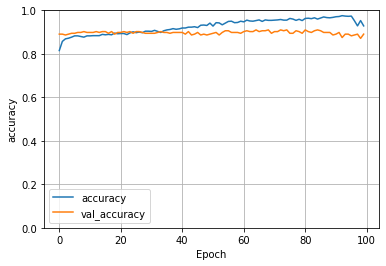

In [72]:
plot_loss(history)

In [73]:
test_evaluation['third_model'] = third_model.evaluate(
    test_features,
    test_labels, verbose=1)
test_evaluation

10/10 [==============================] - 0s 1ms/step - loss: 1.1957 - accuracy: 0.8500 - f1_m: 0.3414


{'first_model': [2.6942336559295654, 0.734375, 0.0992986336350441],
 'second_model': [0.6937808990478516, 0.8968750238418579, 0.3375757336616516],
 'third_model': [1.195664405822754, 0.8500000238418579, 0.3413752615451813]}

The F1 score improved only very slightly, and we fear we have not found the right model for wine quality classification. To show this fact, lets try to use the dummy classifier which always classifies most_frequent label.

### Dummy

In [88]:
dummy = Pipeline(
    [('std_scaler', StandardScaler()), ('Dummy', DummyClassifier(strategy= 'most_frequent'))]
)
dummy.fit(train_features, train_labels)

acc_train = dummy.score(train_features, train_labels) # accuracy on train
acc_test = dummy.score(test_features, test_labels)

dummy_labels = dummy.predict(test_features)
f1_test = f1_score(test_labels, dummy_labels)

test_evaluation['dummy_model'] = [acc_train, acc_test, f1_test]
test_evaluation # Note that the first number in the list in dummy model is accuracy on train model, whilst
# in other models, its cross entropy

{'dummy_model': [0.8608287724784989, 0.878125, 0.0],
 'first_model': [2.6942336559295654, 0.734375, 0.0992986336350441],
 'second_model': [0.6937808990478516, 0.8968750238418579, 0.3375757336616516],
 'third_model': [1.195664405822754, 0.8500000238418579, 0.3413752615451813]}

### Confusion matrix


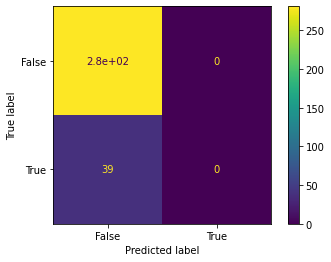

In [90]:
con_dummy = plot_confusion_matrix(dummy, test_features, test_labels) # For dummy

In [97]:
predictions = third_model.predict(test_features)
ypred = (predictions > 0.5)
confusion_matrix(test_labels, ypred)

array([[255,  26],
       [ 22,  17]])

## Conclusion

The dummy classifier which always pick the dominant label, in this case it is bad quality of wine, has comparable accuracy of classification as our neuron models. In the confusion matrices, we see, that the third model, with two hidden layers has slightly better classification scores, having less false positives, and able to make 17 true positives. However, the F1 score of the three neuron models shows, that we are nowhere near having a good reliable model for wine classification. What we can try is to divide the labels into more classes and create multiclassification neuron model
